In [3]:
#!/usr/bin/python
# -*- coding: utf-8 -*-



import numpy as np

## 1.MRP计算return 和value function

图2.2 给出了定义学生马尔科夫奖励过程所需要信息。其中状态集 S 有 7 个状态，状态转换概率如果用矩阵的形式则将是一个 7 ∗ 7 的矩阵，奖励函数则可以用 7 个标量表示，分别表示离开`某一个状态`得到的`即时奖励值`。

图2.3 用于表示计算`某一个状态`下`价值函数`的过程

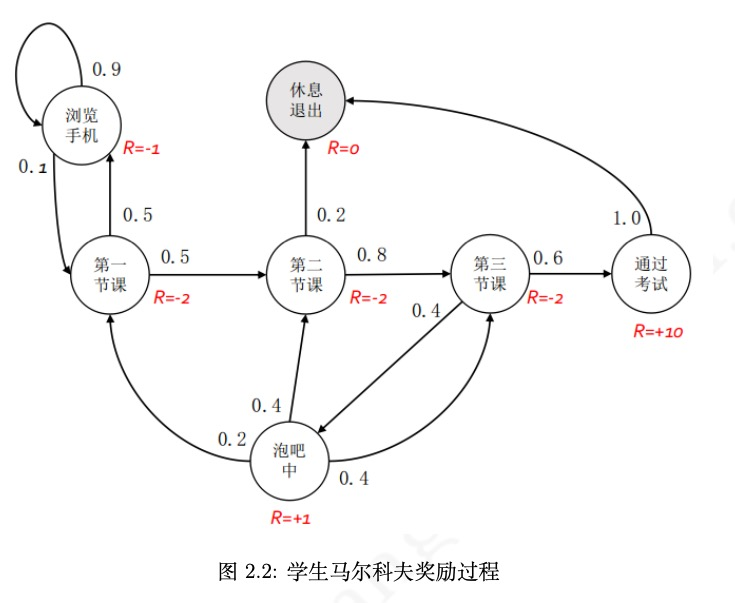

In [4]:
"""
1.根据图2.2，构建MRP，基本参数设置<S,P,R,r>
"""

num_states = 7
# {"0": "C1", "1":"C2", "2":"C3", "3":"Pass", "4":"Pub", "5":"FB", "6":"Sleep"}
# 索引到状态名
i_to_n = {"0": "C1", "1": "C2", "2": "C3", "3": "Pass", "4": "Pub", "5": "FB", "6": "Sleep"}
# 状态名到索引
n_to_i = {}
for i, name in i_to_n.items():
    n_to_i[name] = int(i)

# 状态转移矩阵(按照提前设置好的概率)
Pss = [
    [0.0, 0.5, 0.0, 0.0, 0.0, 0.5, 0.0],
    [0.0, 0.0, 0.8, 0.0, 0.0, 0.0, 0.2],
    [0.0, 0.0, 0.0, 0.6, 0.4, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
    [0.2, 0.4, 0.4, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.0, 0.0, 0.0, 0.0, 0.9, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
]
Pss = np.array(Pss)
# 奖励函数
rewards = [-2, -2, -2, 10, 1, -1, 0]
# 折扣因子
gamma = 0.5


In [5]:
'''
target: 
    计算某一状态t时刻的收获，采用公式G_t = R_t+1 + r*R_t+2...
args:
    start_index 需要计算的状态
    chain   马尔可夫链
    gamma   折扣因子
return：
    re  收获（奖励值）
'''


def compute_return(start_index=0, chain=None, gamma=0.5):
    re, power, gamma = 0.0, 0, gamma
    for i in range(start_index, len(chain)):
        re += np.power(gamma, power) * rewards[n_to_i[chain[i]]]
        power += 1
    return re

In [6]:
# MRP样例

chains = [
    ["C1", "C2", "C3", "Pass", "Sleep"],
    ["C1", "FB", "FB", "C1", "C2", "Sleep"],
    ["C1", "C2", "C3", "Pub", "C2", "C3", "Pass", "Sleep"],
    ["C1", "FB", "FB", "C1", "C2", "C3", "Pub", "C1", "FB", "FB", "FB", "C1", "C2", "C3", "Pub", "C2", "Sleep"]]


compute_return(0, chains[3], gamma=0.5)

-3.196044921875

In [7]:
'''
target:  
    利用求期望，矩阵运算求解return, v_t = E[R_t+1 + r*v(S_t+1)|S_t = s] = （1 - r*P)^-1 * R
args:
    Pss 状态转移矩阵
    rewards 及时奖励 shape(1x7)
    gamma 折扣因子
return：
    value   各个状态的价值函数值
'''


def compute_value_martix(Pss, rewards, gamma=0.5):
    rewards = np.array(rewards).reshape((-1, 1))  # shape(7*1)
    # np.eye(7,7)为 单 位 矩 阵，inv方 法 为 求 矩 阵 的 逆
    values = np.dot(np.linalg.inv(np.eye(7, 7) - gamma * Pss), rewards)
    return values

In [8]:
compute_value_martix(Pss, rewards, gamma=0.99) #gamma为1的时候没有逆矩阵，所以只能设为0.99模拟

array([[-10.51495295],
       [  1.52266514],
       [  4.44780952],
       [ 10.        ],
       [  1.28234728],
       [-18.72459029],
       [  0.        ]])

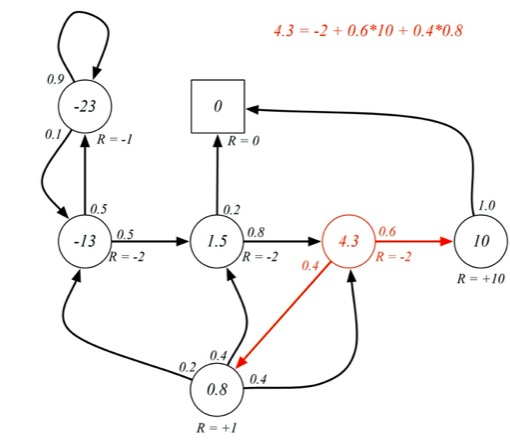

## 2.Bellman方程

本节根据图2.5用来模拟马尔科夫决策过程。与马尔科夫奖励过程不同，马尔科夫决策过程的状态转移概率与奖励函数均与行为相关。（进入到下一步状态均需要通过采取某种行为）
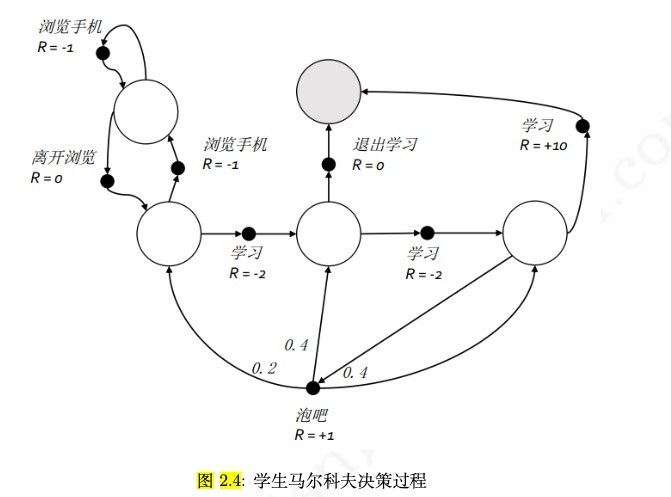

In [9]:
# 导入工具函数:根据状态和行为生成操作相关字典的键，显示字典内容
from utils import str_key, display_dict
# 设置转移概率、奖励值以及读取它们方法
from utils import set_prob, set_reward, get_prob, get_reward  
# 设置状态价值、策略概率以及读取它们的方法
from utils import set_value, set_pi, get_value, get_pi

In [10]:
# 构建学生马尔科夫决策过程 MDP = <S,A,P,R,r>, 一共有5个状态，5个动作
S = ['浏 览 手 机 中', '第 一 节 课', '第 二 节 课', '第 三 节 课', '休 息 中']
A = ['浏 览 手 机', '学 习', '离 开 浏 览', '泡 吧', '退 出 学 习']
R = {}  # 奖励Rsa字典
P = {}  # 状态转移概率Pss'a字典
gamma = 1.0  # 折扣因子

# 根据学生马尔科夫决策过程示例的数据设置状态转移概率和奖励，默认概率为1（即该状态执行某一动作一定能到达下一状态
set_prob(P,S[0],A[0],S[0])# 浏览手机中 - 浏览手机 -> 浏览手机中 
set_prob(P,S[0],A[2],S[1])# 浏览手机中 - 离开浏览 -> 第一节课 
set_prob(P,S[1],A[0],S[0])# 第一节课 - 浏览手机 -> 浏览手机中 
set_prob(P,S[1],A[1],S[2])# 第一节课 - 学习 -> 第二节课
set_prob(P,S[2],A[1],S[3])# 第二节课 - 学习 -> 第三节课 
set_prob(P,S[2],A[4],S[4])# 第二节课 - 退出学习 -> 退出休息 
set_prob(P,S[3],A[1],S[4])# 第三节课 - 学习 -> 退出休息 
set_prob(P,S[3],A[3],S[1],p=0.2)# 第三节课 - 泡吧 -> 第一节课 
set_prob(P,S[3],A[3],S[2],p=0.4)# 第三节课 - 泡吧 -> 第一节课 
set_prob(P,S[3],A[3],S[3],p=0.4)# 第三节课 - 泡吧 -> 第一节课

set_reward(R,S[0],A[0],-1)# 浏览手机中 - 浏览手机 ->-1 
set_reward(R,S[0],A[2], 0)# 浏览手机中 - 离开浏览 ->0 
set_reward(R,S[1],A[0],-1)# 第一节课 - 浏览手机 ->-1 
set_reward(R,S[1],A[1],-2)# 第一节课 - 学习 ->-2 
set_reward(R,S[2],A[1],-2)# 第二节课 - 学习 ->-2
set_reward(R,S[2],A[4], 0)# 第二节课 - 退出学习 ->0 
set_reward(R,S[3],A[1],10)# 第三节课 - 学习 ->10 
set_reward(R,S[3],A[3],+1)# 第三节课 - 泡吧 ->-1

MDP=(S,A,R,P,gamma)

In [11]:
print("----状 态 转 移 概 率 字 典 ( 矩 阵 ) 信 息:----") 
display_dict(P)
print("----奖 励 字 典 ( 函 数 ) 信 息:----") 
display_dict(R)

----状 态 转 移 概 率 字 典 ( 矩 阵 ) 信 息:----
浏 览 手 机 中_浏 览 手 机_浏 览 手 机 中:  1.00
浏 览 手 机 中_离 开 浏 览_第 一 节 课:  1.00
第 一 节 课_浏 览 手 机_浏 览 手 机 中:  1.00
第 一 节 课_学 习_第 二 节 课:  1.00
第 二 节 课_学 习_第 三 节 课:  1.00
第 二 节 课_退 出 学 习_休 息 中:  1.00
第 三 节 课_学 习_休 息 中:  1.00
第 三 节 课_泡 吧_第 一 节 课:  0.20
第 三 节 课_泡 吧_第 二 节 课:  0.40
第 三 节 课_泡 吧_第 三 节 课:  0.40
----奖 励 字 典 ( 函 数 ) 信 息:----
浏 览 手 机 中_浏 览 手 机:  -1.00
浏 览 手 机 中_离 开 浏 览:  0.00
第 一 节 课_浏 览 手 机:  -1.00
第 一 节 课_学 习:  -2.00
第 二 节 课_学 习:  -2.00
第 二 节 课_退 出 学 习:  0.00
第 三 节 课_学 习:  10.00
第 三 节 课_泡 吧:  1.00


#### PS：一个 MDP 中状态的价值是基于某一给定的策略的，要计算或验证该学生马尔科夫决策过程，我们需要先指定一个策略 π，这里考虑使用均一随机策略，也就是在某状态下所有可能的行为被选择的概率相等

In [12]:
# 设置行为策略:pi(a|s)=0.5
Pi = {}
set_pi(Pi,S[0],A[0],0.5)# 浏览手机中 - 浏览手机 
set_pi(Pi,S[0],A[2],0.5)# 浏览手机中 - 离开浏览
set_pi(Pi,S[1],A[0],0.5)# 第一节课 - 浏览手机 
set_pi(Pi,S[1],A[1],0.5)# 第一节课 - 学习 
set_pi(Pi,S[2],A[1],0.5)# 第二节课 - 学习 
set_pi(Pi,S[2],A[4],0.5)# 第二节课 - 退出学习 
set_pi(Pi,S[3],A[1],0.5)# 第三节课 - 学习 
set_pi(Pi,S[3],A[3],0.5)# 第三节课 - 泡吧
print("----状 态 转 移 概 率 字 典 ( 矩 阵 ) 信 息:----") 
display_dict(Pi)
# 初始时价值为空，访问时会返回0
print("----状 态 转 移 概 率 字 典 ( 矩 阵 ) 信 息:----") 
V = {}
display_dict(V)

----状 态 转 移 概 率 字 典 ( 矩 阵 ) 信 息:----
浏 览 手 机 中_浏 览 手 机:  0.50
浏 览 手 机 中_离 开 浏 览:  0.50
第 一 节 课_浏 览 手 机:  0.50
第 一 节 课_学 习:  0.50
第 二 节 课_学 习:  0.50
第 二 节 课_退 出 学 习:  0.50
第 三 节 课_学 习:  0.50
第 三 节 课_泡 吧:  0.50
----状 态 转 移 概 率 字 典 ( 矩 阵 ) 信 息:----


### 计算某一状态 s 时 某行为 a 的行为价值 q(s, a)
$q_{\pi}(s, a)=\mathcal{R}_{s}^{a}+\gamma \sum_{s^{\prime} \in \mathcal{S}} \mathcal{P}_{s s^{\prime}}^{a} v_{\pi}\left(s^{\prime}\right)$

In [13]:
'''
target: 
    计算行为价值函数
args:
    MDP   马尔可夫链
    V   价值函数
    s   状态
    a   行为
return：
    qsa 行为价值
'''


def compute_q(MDP, V, s, a):
    S, A, R, P, gamma = MDP
    qsa = 0
    for state in S:
        qsa += get_prob(P, s, a, state) * get_value(V, state)
    qsa = get_reward(R, s, a) + gamma * qsa
    return qsa

### 计算某一状态 s 时 采用某种策略的状态价值 v(s)
$
v_{\pi}(s)=\sum_{a \in \mathcal{A}} \pi(a \mid s) q_{\pi}(s, a)
$

In [14]:
'''
target: 
    计算状态价值函数
args:
    MDP   马尔可夫链
    V   价值函数
    s   状态
    Pi   策略
return：
    vsa 行为价值
'''


def compute_v(MDP, V, Pi, s):
    S, A, R, P, gamma = MDP
    vs = 0
    for a in A:
        vs += get_pi(Pi, s, a) * compute_q(MDP, V, s, a)
    return vs

In [15]:
# 根据当前策略使用回溯法来更新状态价值，本章不做要求 
def update_V(MDP, V, Pi):
    '''给 定 一 个MDP和 一 个 策 略 ， 更 新 该 策 略 下 的 价 值 函 数V '''
    S, _, _, _, _ = MDP
    V_prime = V.copy() 
    for s in S:
        #set_value(V_prime, s, V_S(MDP, V_prime, Pi, s))
        V_prime[str_key(s)] = compute_v(MDP, V_prime, Pi, s) 
    return V_prime

# 策略评估，得到该策略下最终的状态价值。本章不做要求 
def policy_evaluate(MDP, V, Pi, n):
    '''
    使 用n次 迭 代 计 算 来 评 估 一 个MDP在 给 定 策 略Pi下 的 状 态 价 值 ， 初 始 时 价 值 为V
    '''
    for i in range(n):
        V = update_V(MDP, V, Pi)
        #display_dict(V)
    return V
V = policy_evaluate(MDP, V, Pi, 100) 
display_dict(V)

浏 览 手 机 中:  -2.31
第 一 节 课:  -1.31
第 二 节 课:  2.69
第 三 节 课:  7.38
休 息 中:  0.00


In [16]:
# test v_pi(s)
v = compute_v(MDP, V, Pi, "第 三 节 课") 
print("第三节课在当前策略下的最终价值为:{:.2f}".format(v))

第三节课在当前策略下的最终价值为:7.38


实现最终目的：计算最优策略-》找到最大状态价值v-》最大的行为价值q
$$
v_{*}(s)=\max _{a} q_{*}(s, a)
$$
$$
q_{*}(s, a)=\mathcal{R}_{s}^{a}+\gamma \sum_{s^{\prime} \in \mathcal{S}} \mathcal{P}_{s s^{\prime}}^{a} v_{*}\left(s^{\prime}\right)
$$

In [17]:
def compute_v_from_max_q(MDP,V,s):
    S, A, R, P, gamma = MDP
    vs = -float('inf')
    for a in A:
        qsa = compute_q(MDP,V,s,a)
        if qsa >= vs:
            vs = qsa
    return vs

In [18]:
 def update_V_without_pi(MDP, V): 
    '''在不依赖策略的情况下直接通过后续状态的价值来更新状态价值 '''
    S, _, _, _, _ = MDP
    V_prime = V.copy()
    for s in S:
    #set_value(V_prime, s, compute_v_from_max_q(MDP, V_prime, s))
        V_prime[str_key(s)] = compute_v_from_max_q(MDP, V_prime, s) 
    return V_prime
# 价值迭代，本章不作要求
def value_iterate(MDP, V, n): 
    '''价值迭代
    '''
    for i in range(n):
        V = update_V_without_pi(MDP, V)
    return V
V = {}
# 通过价值迭代得到最优状态价值及 
V_star = value_iterate(MDP, V, 4) 
display_dict(V_star)

浏 览 手 机 中:  6.00
第 一 节 课:  6.00
第 二 节 课:  8.00
第 三 节 课:  10.00
休 息 中:  0.00


In [ ]:
#验证最优行为价值函数
s, a = "第 三 节 课", "泡 吧"
q = compute_q(MDP, V_star, s, a)
print("在 状 态{}选 择 行 为{}的 最 优 价 值 为:{:.2f}".format(s,a,q))

在 状 态第 三 节 课选 择 行 为泡 吧的 最 优 价 值 为:9.40


In [ ]:
# display q_star
def display_q_star(MDP, V_star):
    S, A, _, _, _ = MDP
    for s in S:
        for a in A:
            print("q*({},{}):{}".format(s,a, compute_q(MDP, V_star, s, a)))

In [ ]:
display_q_star(MDP, V_star)